<h1><center> STATS PROJECT - HARI PURNAPATRE</center></h1>

#### This project is a part of the Rossmann Store Sales Prediction competition where I am predicting their daily sales for up to six weeks in advance. 
#### The store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### Files

**train.csv - historical data including Sales**

**test.csv - historical data excluding Sales**

**sample_submission.csv - a sample submission file in the correct format**

**store.csv - supplemental information about the stores**

### Data fields

**Most of the fields are self-explanatory. The following are descriptions for those that aren't.**

**Id - an Id that represents a (Store, Date) duple within the test set**

**Store - a unique Id for each store**

**Sales - the turnover for any given day (this is what you are predicting)**

**Customers - the number of customers on a given day**

**Open - an indicator for whether the store was open: 0 = closed, 1 = open**

**StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays.**

**Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None**

**SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools**

**StoreType - differentiates between 4 different store models: a, b, c, d**

**Assortment - describes an assortment level: a = basic, b = extra, c = extended**

**CompetitionDistance - distance in meters to the nearest competitor store**

**CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened**

**Promo - indicates whether a store is running a promo on that day**

**Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating**

**Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2**

**PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store**

## Import Libraries and Load Dataset

In [314]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [315]:
df_store = pd.read_csv('/Users/haripurnapatre/rossmann-store-sales/store.csv')
df_train = pd.read_csv('/Users/haripurnapatre/rossmann-store-sales/train.csv')
df_test = pd.read_csv('/Users/haripurnapatre/rossmann-store-sales/test.csv')

/Users/haripurnapatre/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Checking and cleaning duplicate values 

In [316]:
print('Train dataset has duplicates:',df_train['Store'].duplicated().any())
print('Store Dataset has duplicates:',df_store['Store'].duplicated().any())

Train dataset has duplicates: True
Store Dataset has duplicates: False


In [317]:
df_train= df_train.drop_duplicates()

## Data Exploration, Cleaning and Visualization

### For all stores, promotion leads to increased sales and customers.

<AxesSubplot:xlabel='Promo', ylabel='Customers'>

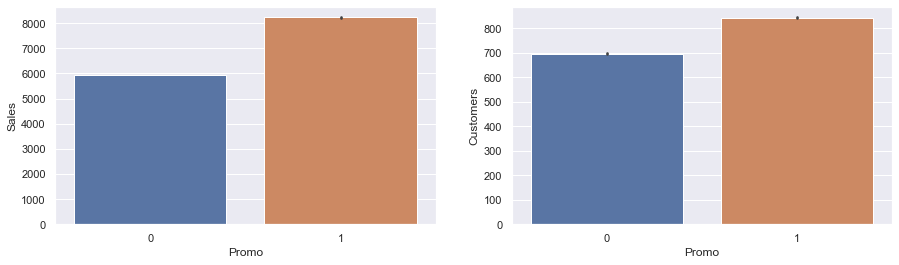

In [129]:
sns.set(rc={'figure.figsize':(15,4)})
f, axes = plt.subplots(1,2)
sns.barplot(x="Promo", y="Sales", data=df_train, ax=axes[0])
sns.barplot(x="Promo", y="Customers", data=df_train, ax=axes[1])

In [130]:
df_train['StateHoliday'].value_counts(normalize=True)* 100

0.0    100.0
Name: StateHoliday, dtype: float64

In [131]:
df_train['SchoolHoliday'].value_counts(normalize=True)* 100

0    80.642048
1    19.357952
Name: SchoolHoliday, dtype: float64

In [132]:
df_train['StateHoliday'].head(2)

0    0.0
1    0.0
Name: StateHoliday, dtype: float64

**We can see that there state holidays are categorical and in the context of this problem we need to know whether there is a holiday or not.**  

**So we will map values to clean this varibale to see how many state holidays there were throughout.** 

In [318]:
m = {0: 0, "0": 0, "a": 1, "b": 1, "c": 1}
df_train["StateHoliday"] = df_train["StateHoliday"].map(m)
df_test["StateHoliday"] = df_test["StateHoliday"].map(m)
df_store["Assortment"] = df_store["Assortment"].map(m)

**We can see that the Sales are more when the there is a School Holiday sales are more but when there is a State Holiday we can see that Sales Decline.**

Text(0.5, 1.0, 'State Holiday')

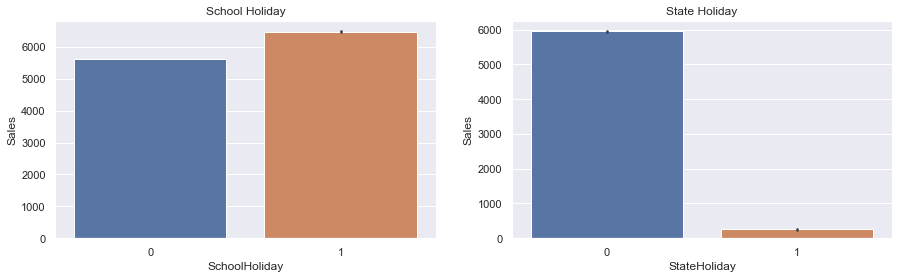

In [319]:
f, axes = plt.subplots(1, 2)
sns.barplot(x="SchoolHoliday", y="Sales", data=df_train, ax=axes[0]).set_title('School Holiday')

sns.barplot(x="StateHoliday", y="Sales", data=df_train, ax=axes[1]).set_title('State Holiday')

**To further investgate the trend in sales and customers we will create some visualizations. But for that it is important to clean the Date columns first as ut will be easier to group by them.**

In [320]:
df_train['year'] = pd.DatetimeIndex(df_train['Date']).year
df_test['year'] = pd.DatetimeIndex(df_test['Date']).year

df_train['month'] = pd.DatetimeIndex(df_train['Date']).month
df_test['month'] = pd.DatetimeIndex(df_test['Date']).month

**We can see that Sales spike a every December this would be because people buy gifts during Christmas. We can also observe that Customers and Sales are highly correlated as the graph show similar variation. We will explore this further ahead.**

In [321]:
meansales = df_train.groupby(['month','year'])["Sales"].mean()
custmean = df_train.groupby(['month','year'])["Customers"].mean()

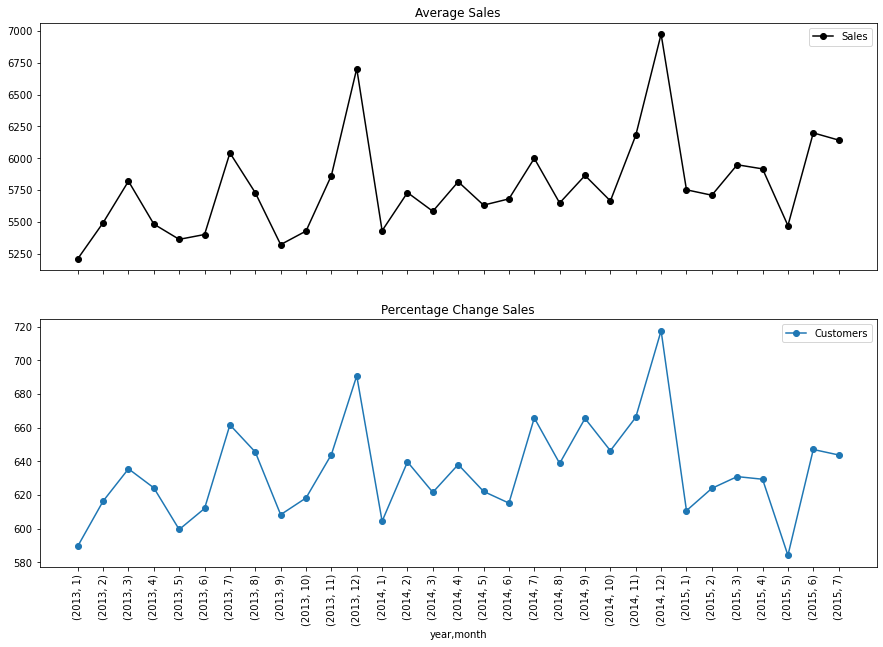

In [59]:
fig, (axes1,axes2) = plt.subplots(2,1, figsize=(15,10), sharex=True)
axes1 = df_train.groupby(['year', 'month'])["Sales"].mean().plot(legend =True, ax=axes1,title="Average Sales", color = 'Black',marker = 'o')
axes1.set_xticks(range(len(meansales)))
df_train.groupby(['year', 'month'])["Customers"].mean().plot(legend =True, ax=axes2,title="Percentage Change Sales",marker = 'o')
plt.xticks(rotation=90)
plt.show()

### Moving Averages to understand the trend.

In [105]:
df_train['RollingMean'] = df_train['Sales'].rolling(window=5).mean()

In [106]:
df_train['RollingMean'] = df_train['RollingMean'].fillna(0)

**Rolling Averages or Moving Averages smooths out price trends by filtering out the noise from random short-term price fluctuations. This helps us understand seasonality in the data. We will make a feature from moving averages to help increase our score.**

<AxesSubplot:title={'center':'RollingMean'}, xlabel='month,year'>

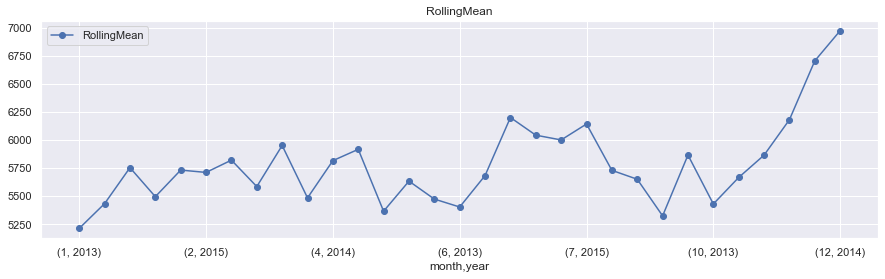

In [107]:
df_train.groupby(['month','year'])["RollingMean"].mean().plot(legend =True, title="RollingMean",marker = 'o')


In [108]:
df_train = df_train.drop(columns = 'RollingMean')

### For all stores, promotion leads to increased sales and customers.

<AxesSubplot:xlabel='Promo', ylabel='Customers'>

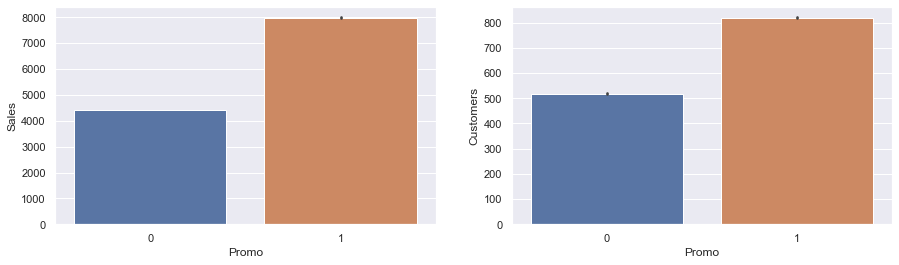

In [322]:
f, axes = plt.subplots(1, 2)
sns.barplot(x="Promo", y="Sales", data=df_train, ax=axes[0])
sns.barplot(x="Promo", y="Customers", data=df_train, ax=axes[1])

### We can see that the stores are mostly open during the weekdays so thats when most of the sales happens.

<AxesSubplot:xlabel='Open', ylabel='count'>

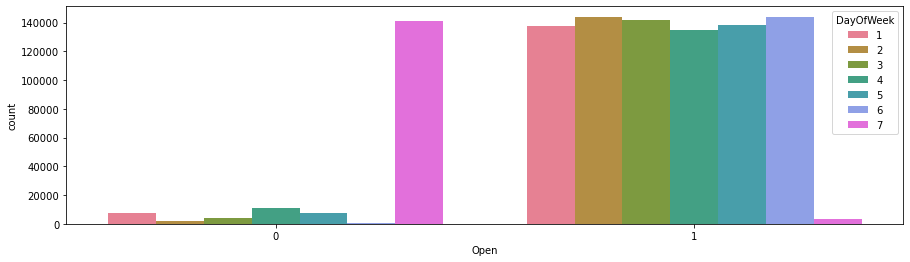

In [85]:
fig, (axis1) = plt.subplots(1,1,figsize=(15,4))
sns.countplot(x='Open',hue='DayOfWeek', data=df_train,palette="husl", ax=axis1)

### Autocorrelation

**Autocorrelation plot is designed to show whether the elements of a time series are positively correlated, negatively correlated, or independent of each other. On the graph, there is a vertical line (a "spike") corresponding to each lag. The height of each spike shows the value of the autocorrelation function for the lag.  Each spike is significantly different from zero, that is evidence of autocorrelation. This means that when sales price increases it tends to continue rising and when it falls it tends to continue to fall.**

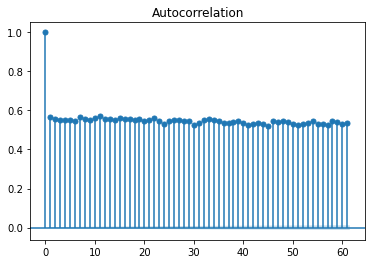

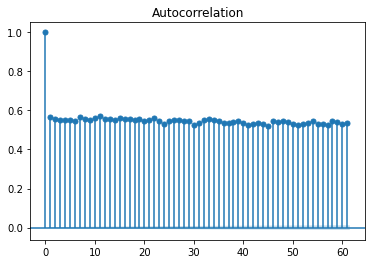

In [86]:
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
temp = df_train[['Sales']]
temp = pd.DataFrame(temp)
plot_acf(temp)

**Another visualization to understand autocorrelation better.**

In [100]:
avg_sales = df_train.groupby('Store')[["Sales"]].mean()
df_merge = pd.merge(avg_sales, df_store, on='Store')

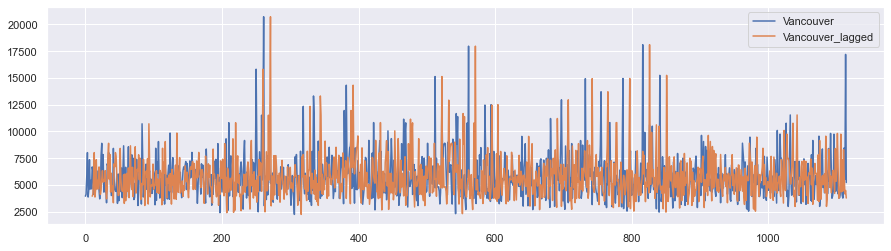

In [109]:
df_merge["Sales"].plot(legend=True)
shifted = df_merge["Sales"].shift(10).plot(legend=True)
shifted.legend(['Vancouver','Vancouver_lagged'])
plt.show()

### We can see that whenever the stores are closed there is no sales so we will only take records of when the stores are open.

In [174]:
df_train[df_train["Open"] == 0].head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,year,month
291,292,5,2015-07-31,0,0,0,1,0,1,2015,7
875,876,5,2015-07-31,0,0,0,1,0,1,2015,7
1406,292,4,2015-07-30,0,0,0,1,0,1,2015,7
1990,876,4,2015-07-30,0,0,0,1,0,1,2015,7
2521,292,3,2015-07-29,0,0,0,1,0,1,2015,7


In [323]:
df_train = df_train[df_train["Open"] != 0]

**By visualizations we can see that promo codes are null when stores are closed so we will replace them with 0.**

In [324]:
df_store["Promo2SinceWeek"] = df_store["Promo2SinceWeek"].fillna(0)
df_store["Promo2SinceYear"] = df_store["Promo2SinceYear"].fillna(0)
df_store["PromoInterval"] = df_store["PromoInterval"].fillna(0)

**We will use one-hot encoding to convert PromoInterval to numerical variables and we will drop the first value to avoid the dummy-variable trap which introduces multi-collinearity.**

In [182]:
df_store['PromoInterval'].value_counts()

0                   544
Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64

In [325]:
df_store = pd.get_dummies(df_store, columns=['PromoInterval'], drop_first=True)
df_store.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec"
0,1,c,1,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0
1,2,a,1,570.0,11.0,2007.0,1,13.0,2010.0,0,1,0
2,3,a,1,14130.0,12.0,2006.0,1,14.0,2011.0,0,1,0
3,4,c,1,620.0,9.0,2009.0,0,0.0,0.0,0,0,0
4,5,a,1,29910.0,4.0,2015.0,0,0.0,0.0,0,0,0


In [185]:
df_store['StoreType'].value_counts()

a    602
d    348
c    148
b     17
Name: StoreType, dtype: int64

In [326]:
df_store = pd.get_dummies(df_store, columns=['StoreType'], drop_first=True)

### Distribution of Competition Distance

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='CompetitionDistance', ylabel='Sales'>

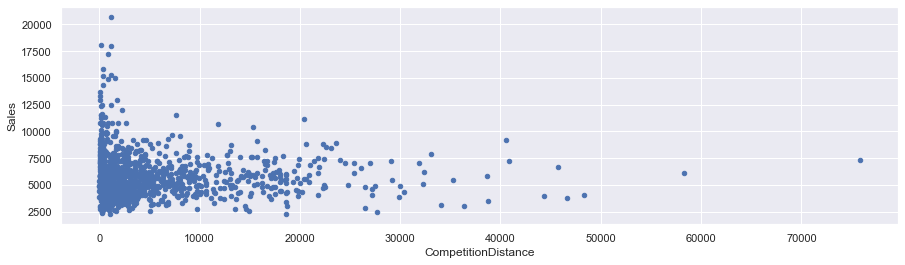

In [187]:
df_merge.plot(kind='scatter',x='CompetitionDistance',y='Sales',figsize=(15,4))

In [327]:
df_store["CompetitionDistance"] = df_store["CompetitionDistance"].fillna(df_store["CompetitionDistance"].median())
df_store["CompetitionOpenSinceMonth"] = df_store["CompetitionOpenSinceMonth"].fillna(0)
df_store["CompetitionOpenSinceYear"] = df_store["CompetitionOpenSinceYear"].fillna(0)

### Merging Cleaned Datasets 

In [328]:
sales1 = df_train.groupby('Store')[["Sales", "Customers"]].mean()
sales_customers_df = pd.DataFrame({'Store':sales1.index,
                      'Sales':sales1["Sales"], 'Customers': sales1["Customers"],
                                  }, 
                      columns=['Store', 'Sales', 'Customers'])
sales_customers_df.index.name = None
merged_df = pd.merge(sales_customers_df, df_store, on='Store')

### Standard Scaler - Scaling the data 

In [330]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(merged_df)


In [331]:
merged_df = pd.DataFrame(scaled_features, index=merged_df.index, columns=merged_df.columns)

### Spliting Data to create train and test datasets.

In [334]:
from sklearn.model_selection import train_test_split
y = merged_df.Sales
merged_df = merged_df.drop(columns = 'Sales')
merged_df = merged_df.drop(columns = 'Store')

X = merged_df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
                                                    random_state=1)

### Fitting Baseline Linear Regression Model.

In [335]:
from sklearn.linear_model import LinearRegression
 
linear = LinearRegression()
linear.fit(X_train, y_train)
r2 = linear.score(X_test, y_test)
print('Adjusted R Squared:',linear.score(X_test, y_test) * 100/1 - (1-r2)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))

Adjusted R Squared: 79.12511074147466


### Cross Validation Strategy for Regression.

**Stratified KFold - This cross-validation is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class. This helps us to prevent overfitting the data by making the model more generalized as it trains on different folds of data.**

**Cross Validation is usually not done for Regression Models but in order to get the benefits of cross validation for regression I created a** ***ycat value by making cuts in the data***. **This helped stratified kfold to get categories in order to create folds.**

In [336]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import r2_score
i = 1
aucs = []
y_cat = pd.cut(y_train, 10, labels=range(10))
for train_index,test_index in StratifiedKFold(5).split(X_train, y_cat):
    x1_train, x1_test, y1_train, y1_test = X_train.iloc[train_index], X_train.iloc[test_index], y_train.iloc[train_index], y_train.iloc[test_index]
    linear.fit(x1_train, y1_train)
    y1_pred = linear.predict(x1_train)
    r2score = r2_score(y1_pred, y1_train)
    adjusted_r_squared = 1 - (1-r2score)*(len(y1_train)-1)/(len(y1_train)-x1_train.shape[1]-1)
    print("Adjusted R Squared Per fold :", adjusted_r_squared)
    aucs.append(adjusted_r_squared)

Adjusted R Squared Per fold : 0.7471234319240092
Adjusted R Squared Per fold : 0.7452378202426015
Adjusted R Squared Per fold : 0.7519262318807808
Adjusted R Squared Per fold : 0.7392276725855472
Adjusted R Squared Per fold : 0.7223084661590968


/Users/haripurnapatre/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


**We can see that that our Adjusted R-Squared Score (72.23), is less than our baseline Model Score (79.12), this is because the score we get from Stratified Kfold is more generalized and will work better with real world data as the model is less prone to overfitting.**

In [337]:
print("Adjusted R Squared Score:" ,np.mean(adjusted_r_squared)*100)

Adjusted R Squared Score: 72.23084661590968


### Stationary Time Series
**Stationarity is a property of a time series. A stationary series is one where the values of the series is not a function of time. So, the values are independent of time.**

**Hence the statistical properties of the series like mean, variance and autocorrelation are constant over time.**

**One of the assumptions of linear regression is that the residuals are not correlated and with Stationary time series the assuption is satisfied which allows us to use linear regression effectively in a time series problem.**




### Detecting Stationary Time Series (Augmented Dickey Fuller test)

**Augmented Dickey-Fuller Test is a well known statistical test that can help determine if your time series is stationary.**

**Null Hypothesis : There is the presence of a unit root. Stationarity does'nt exist.**

**Alternate Hypothesis : There is no unit root. In other words, Stationarity exist.**

In [338]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(y)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -32.867817
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


**As THE P-Value is less than the Significance Level(0.05), we reject the Null Hypothesis that the time series contains a unit root. By rejecting the Null hypothesis, we can conclude that the time series is stationary.**

**To better interpret the linear regression model we can see its summary.**

In [339]:
import statsmodels.api as sm
results = sm.OLS(y_train,X_train).fit()
results.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Sales   R-squared (uncentered):                   0.089
Model:                            OLS   Adj. R-squared (uncentered):              0.072
Method:                 Least Squares   F-statistic:                              5.353
Date:                Sun, 24 Apr 2022   Prob (F-statistic):                    1.08e-08
Time:                        23:06:00   Log-Likelihood:                         -6867.7
No. Observations:                 669   AIC:                                  1.376e+04
Df Residuals:                     657   BIC:                                  1.381e+04
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Customers                       2384.1121    326.528      7.301      0.000    1742.948    3025.276
Assortment                       1.09e-08   1.83e-08      0.594      0.553   -2.51e-08    4.69e-08
CompetitionDistance             -241.0087    313.426     -0.769      0.442    -856.447     374.429
CompetitionOpenSinceMonth       -308.7880    432.840     -0.713      0.476   -1158.705     541.129
CompetitionOpenSinceYear         598.0430    440.490      1.358      0.175    -266.895    1462.981
Promo2                          8.701e+04   1.46e+05      0.595      0.552      -2e+05    3.74e+05
Promo2SinceWeek                  -32.5683    430.986     -0.076      0.940    -878.844     813.707
Promo2SinceYear                -1.412e+05   2.38e+05     -0.594      0.553   -6.08e+05    3.26e+05
PromoInterval_Feb,May,Aug,Nov    3.52e+04   5.88e+04      0.599      0.549   -8.02e+04    1.51e+05
PromoInterval_Jan,Apr,Jul,Oct   4.977e+04    8.4e+04      0.593      0.554   -1.15e+05    2.15e+05
PromoInterval_Mar,Jun,Sept,Dec  3.198e+04   5.38e+04      0.595      0.552   -7.36e+04    1.38e+05
StoreType_b                     -722.6120    313.003     -2.309      0.021   -1337.219    -108.005
StoreType_c                     -313.8116    290.541     -1.080      0.280    -884.313     256.690
StoreType_d                      322.1264    297.466      1.083      0.279    -261.972     906.225
==============================================================================
Omnibus:                        5.761   Durbin-Watson:                   0.063
Prob(Omnibus):                  0.056   Jarque-Bera (JB):                6.835
Skew:                           0.105   Prob(JB):                       0.0328
Kurtosis:                       3.449   Cond. No.                     4.01e+17
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 1.41e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## VIF
### By looking at the model we can see that mulicollinearity might exist in the data so we will use Variation Inflation Factor (VIF) to handle this mulicollinearity.

In [340]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [341]:
def compute_vif(considered_features):
    
    X1 = merged_df[considered_features]
    # the calculation of variance inflation requires a constant
    X1['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X1.columns
    vif["VIF"] = [variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [342]:
merged_df['Sales']= y

In [343]:
compute_vif(merged_df.columns)

/Users/haripurnapatre/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/haripurnapatre/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Variable,VIF
0,Customers,6.727921e+00
1,Assortment,NaN
2,CompetitionDistance,1.121460e+00
3,CompetitionOpenSinceMonth,2.648987e+00
4,CompetitionOpenSinceYear,2.678212e+00
5,Promo2,inf
6,Promo2SinceWeek,2.520562e+00
7,Promo2SinceYear,7.678339e+05
8,"PromoInterval_Feb,May,Aug,Nov",inf
9,"PromoInterval_Jan,Apr,Jul,Oct",inf


In [344]:
corr = merged_df.corr()
corr.style.background_gradient(cmap='coolwarm')

/Users/haripurnapatre/opt/anaconda3/lib/python3.9/site-packages/pandas/io/formats/style.py:2813: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/Users/haripurnapatre/opt/anaconda3/lib/python3.9/site-packages/pandas/io/formats/style.py:2814: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,Customers,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",StoreType_b,StoreType_c,StoreType_d,Sales
Customers,1.000000,nan,-0.160958,-0.020732,0.005387,-0.227442,-0.149209,-0.227411,-0.095782,-0.121390,-0.093064,0.438327,0.063682,-0.286655,0.829794
Assortment,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
CompetitionDistance,-0.160958,nan,1.000000,-0.031303,-0.000591,-0.145098,-0.129552,-0.145164,-0.051841,-0.087643,-0.053561,-0.070517,-0.095824,0.131183,-0.041649
CompetitionOpenSinceMonth,-0.020732,nan,-0.031303,1.000000,0.785030,-0.080671,-0.106586,-0.080591,-0.024156,-0.051095,-0.031184,-0.040717,0.016800,-0.042466,-0.021816
CompetitionOpenSinceYear,0.005387,nan,-0.000591,0.785030,1.000000,-0.095603,-0.120918,-0.095526,-0.076366,-0.003072,-0.074564,-0.040986,0.033958,-0.076825,0.008309
Promo2,-0.227442,nan,-0.145098,-0.080671,-0.095603,1.000000,0.759193,0.999999,0.354597,0.639671,0.316365,-0.054265,-0.004188,0.092109,-0.165154
Promo2SinceWeek,-0.149209,nan,-0.129552,-0.106586,-0.120918,0.759193,1.000000,0.759023,0.289821,0.482425,0.222642,-0.045898,-0.028984,0.072884,-0.074943
Promo2SinceYear,-0.227411,nan,-0.145164,-0.080591,-0.095526,0.999999,0.759023,1.000000,0.354499,0.639640,0.316520,-0.054227,-0.004231,0.092064,-0.165183
"PromoInterval_Feb,May,Aug,Nov",-0.095782,nan,-0.051841,-0.024156,-0.076366,0.354597,0.289821,0.354499,1.000000,-0.238083,-0.117750,-0.022397,-0.010342,0.038756,-0.078659
"PromoInterval_Jan,Apr,Jul,Oct",-0.121390,nan,-0.087643,-0.051095,-0.003072,0.639671,0.482425,0.639640,-0.238083,1.000000,-0.212414,-0.033649,-0.037284,0.052538,-0.060585


### By looking at the VIF score and Correlation Matrix We can see that there is multicollinearity and we will remove some features based on our observation to deal with this multicollinearity.

In [345]:
merged_df = merged_df.drop(columns = 'PromoInterval_Jan,Apr,Jul,Oct')
merged_df = merged_df.drop(columns = 'Promo2SinceYear')


**We can now see that the multicollinearity has been handled and we can fit our model to get a better score.**

In [346]:
compute_vif(merged_df.columns)

/Users/haripurnapatre/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,Variable,VIF
0,Customers,6.712530
1,Assortment,NaN
2,CompetitionDistance,1.118893
3,CompetitionOpenSinceMonth,2.648182
4,CompetitionOpenSinceYear,2.677006
5,Promo2,2.804565
6,Promo2SinceWeek,2.408337
7,"PromoInterval_Feb,May,Aug,Nov",1.241739
8,"PromoInterval_Mar,Jun,Sept,Dec",1.214216
9,StoreType_b,1.584909


In [347]:
merged_df = merged_df.drop(columns = 'Sales')

In [348]:
X = merged_df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
                                                    random_state=1)

In [355]:
linear = LinearRegression()
linear.fit(X_train, y_train)
r2 = linear.score(X_test, y_test)
print('Adjusted R Squared:',linear.score(X_test, y_test) * 100/1 - (1-r2)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))

Adjusted R Squared: 79.22887478330163


### By removing multicollinearity using VIF and Correlation Matrix our model score increased by 2 %.

In [350]:
aucs = []
y_cat = pd.cut(y_train, 10, labels=range(10))
for train_index,test_index in StratifiedKFold(5).split(X_train, y_cat):
    x1_train, x1_test, y1_train, y1_test = X_train.iloc[train_index], X_train.iloc[test_index], y_train.iloc[train_index], y_train.iloc[test_index]
    linear.fit(x1_train, y1_train)
    y1_pred = linear.predict(x1_train)
    r2score = r2_score(y1_pred, y1_train)
    adjusted_r_squared = 1 - (1-r2score)*(len(y1_train)-1)/(len(y1_train)-x1_train.shape[1]-1)
    print("Adjusted R Squared Per fold :", adjusted_r_squared)
    aucs.append(adjusted_r_squared)
print("Adjusted R Squared of Linear Regression model is :",np.mean(aucs) * 100)

Adjusted R Squared Per fold : 0.7449026188745961
Adjusted R Squared Per fold : 0.7436795286680427
Adjusted R Squared Per fold : 0.7513830034927704
Adjusted R Squared Per fold : 0.7384110866706577
Adjusted R Squared Per fold : 0.721709496235146
Adjusted R Squared of Linear Regression model is : 74.00171467882424


/Users/haripurnapatre/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


### Ridge Regression

In [351]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
aucs2 = []
clf = Ridge(alpha=.90)
y_cat = pd.cut(y_train, 10, labels=range(10))
for train_index,test_index in StratifiedKFold(5).split(X_train, y_cat):
    x1_train, x1_test, y1_train, y1_test = X_train.iloc[train_index], X_train.iloc[test_index], y_train.iloc[train_index], y_train.iloc[test_index]
    clf.fit(x1_train, y1_train)
    y1_pred = clf.predict(x1_train)
    r2score = r2_score(y1_pred, y1_train)
    adjusted_r_squared = 1 - (1-r2score)*(len(y1_train)-1)/(len(y1_train)-x1_train.shape[1]-1)
    print("Adjusted R Squared Per fold :", adjusted_r_squared)
    aucs2.append(adjusted_r_squared)
print("Adjusted R Squared of Ridge Regression model is :",np.mean(aucs2) * 100)

Adjusted R Squared Per fold : 0.7436777340762248
Adjusted R Squared Per fold : 0.7423275427744707
Adjusted R Squared Per fold : 0.7499723634703508
Adjusted R Squared Per fold : 0.7370715947252082
Adjusted R Squared Per fold : 0.7202864944339532
Adjusted R Squared of Ridge Regression model is : 73.86671458960414


/Users/haripurnapatre/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


### Random Forest Regression

**We can see that Random forest regressor overfits the data.**

In [352]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
rf = RandomForestRegressor()
aucs3 = []
y_cat = pd.cut(y_train, 10, labels=range(10))
for train_index,test_index in StratifiedKFold(5).split(X_train, y_cat):
    x1_train, x1_test, y1_train, y1_test = X_train.iloc[train_index], X_train.iloc[test_index], y_train.iloc[train_index], y_train.iloc[test_index]
    rf.fit(x1_train, y1_train)
    y1_pred = rf.predict(x1_train)
    r2score = r2_score(y1_pred, y1_train)
    adjusted_r_squared = 1 - (1-r2score)*(len(y1_train)-1)/(len(y1_train)-x1_train.shape[1]-1)
    print("Adjusted R Squared Per fold :", adjusted_r_squared)
    aucs3.append(adjusted_r_squared)
print("Adjusted R Squared of Random Forest Regression model is :",np.mean(aucs3) * 100)

/Users/haripurnapatre/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Adjusted R Squared Per fold : 0.9630865156267661
Adjusted R Squared Per fold : 0.9603158310598681
Adjusted R Squared Per fold : 0.9639926876652672
Adjusted R Squared Per fold : 0.9578497347106433
Adjusted R Squared Per fold : 0.9597938434019178
Adjusted R Squared of Random Forest Regression model is : 96.10077224928926


### XG Boost Regression

**We can see that XGBoost regressor overfits the data heavily.**

In [356]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
model = XGBRegressor()
aucs4 = []
y_cat = pd.cut(y_train, 10, labels=range(10))
for train_index,test_index in StratifiedKFold(5).split(X_train, y_cat):
    x1_train, x1_test, y1_train, y1_test = X_train.iloc[train_index], X_train.iloc[test_index], y_train.iloc[train_index], y_train.iloc[test_index]
    model.fit(x1_train, y1_train)
    y1_pred = model.predict(x1_train)
    r2score = r2_score(y1_pred, y1_train)
    adjusted_r_squared = 1 - (1-r2score)*(len(y1_train)-1)/(len(y1_train)-x1_train.shape[1]-1)
    print("Adjusted R Squared Per fold :", adjusted_r_squared)
    aucs4.append(adjusted_r_squared)
print("Adjusted R Squared of XG Boost Regression model is :",np.mean(aucs4) * 100)

/Users/haripurnapatre/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Adjusted R Squared Per fold : 0.9992961983569587
Adjusted R Squared Per fold : 0.9992466775804443
Adjusted R Squared Per fold : 0.9993152386355367
Adjusted R Squared Per fold : 0.9994206574889115
Adjusted R Squared Per fold : 0.9991944386660156
Adjusted R Squared of XG Boost Regression model is : 99.92946421455734


## We can see that linear regression and Ridge Regression works best on the data to give the most Generalized model compared to XGBoost and Random Forest that overfit the data.

In [357]:
print("Adjusted R Squared of Linear Regression model is :",np.mean(aucs) * 100)
print("Adjusted R Squared of Ridge Regression model is :",np.mean(aucs2) * 100)
print("Adjusted R Squared of Random Forest Regression model is :",np.mean(aucs3) * 100)
print("Adjusted R Squared of XG Boost Regression model is :",np.mean(aucs4) * 100)

Adjusted R Squared of Linear Regression model is : 74.00171467882424
Adjusted R Squared of Ridge Regression model is : 73.86671458960414
Adjusted R Squared of Random Forest Regression model is : 96.10077224928926
Adjusted R Squared of XG Boost Regression model is : 99.92946421455734
